### Imports

In [1]:
# Python standard library
import csv
import sys

# Scientific computing
import numpy as np
import scipy
import scipy.interpolate

import matplotlib.pyplot as plt
%matplotlib inline

# Pore stats
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi')
import optical_imaging as oi
import oi_file

## Load data

#### Load video

In [2]:
date = '10-10-2017'
particle = '293-T_0'
channel = '10-20-10_1'
file_index = '0'

base_path = oi_file.data_base_path

oi_vid_file_path = base_path + date + '/' + particle + '/' + channel + '/oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + '/' + particle + '/' + channel + '/oi/events/test_camera_' + file_index + '_events.json'

In [3]:
# Load video
oi_res_x = 384
oi_res_y = 112
oi_fps = 250000

oi_vid = oi_file.Video(oi_vid_file_path, oi_res_x, oi_res_y, oi_fps)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

#### Create stage

[ 0.01249902  0.99992188]


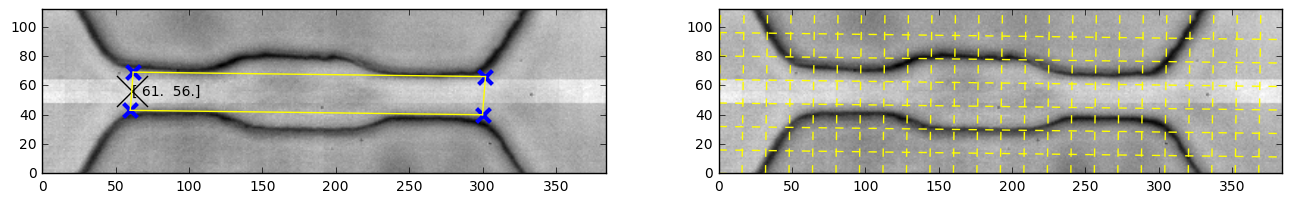

In [4]:
reload(oi)

template_index = 100

template_frame = oi_vid.get_frame(template_index)

stage_file_path = base_path + '/' + date + '/' + particle + '/' + channel + '/oi/stage/stage_' + file_index
cs = oi.load_stage_file(stage_file_path)

c0 = cs[0]
c1 = cs[1]
c2 = cs[2]
c3 = cs[3]

oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

#### Load ellipses

In [5]:
oi_ellipse_base_path = '../data/'
oi_ellipse_path = oi_ellipse_base_path + date + '/' + particle + '/' + channel + '/' + file_index + '/ellipses'

ellipsess = []


with open(oi_ellipse_path, 'r') as file_handle:
    file_reader = csv.reader(file_handle, delimiter = '\t')
    
    # Skip header
    header_length = 2
    for i in range(header_length):
        next(file_reader)
        
        
    for row in file_reader:
        
        if row[0] == 'event #':
            # New event
            ellipsess.append([])
            continue
            
        else:
            ellipse = []
            for ele in row:
                try:
                    ellipse.append(float(ele))
                except:
                    ellipse.append(0)
                    
            ellipsess[-1].append(ellipse)

#### Filter ellipses and events

In [6]:
# Load keep indices
filter_file_path = '../data/' + date + '/' + particle + '/' + channel + '/' + file_index + '/filter'
with open(filter_file_path, 'r') as filter_file_handle:
    filter_file_reader = csv.reader(filter_file_handle, delimiter = '\t')
    for row in filter_file_reader:
        if row[0] == 'events':
            keep_indices = [int(ele) for ele in row[1:]]
            




# Manual filter
manual_filter_file_path = filter_file_path.replace('filter', 'manual_filter')
manual_remove_indices = []
with open(manual_filter_file_path, 'r') as manual_filter_file_handle:
    reader = csv.reader(manual_filter_file_handle)
    for row in reader:
        manual_remove_indices.append(int(row[0]))
        
keep_indices = [keep_index for keep_index in keep_indices if keep_index not in manual_remove_indices]
    
    
print 'loaded keep indices (', len(keep_indices), 'events total):\n', keep_indices
filtered_oi_events = [oi_events[i] for i in range(len(oi_events)) if i in keep_indices]
filtered_ellipsess = [ellipsess[i] for i in range(len(ellipsess)) if i in keep_indices]

loaded keep indices ( 89 events total):
[3, 4, 8, 9, 13, 24, 29, 32, 40, 43, 55, 57, 59, 65, 66, 74, 76, 84, 85, 86, 87, 99, 109, 114, 115, 116, 121, 127, 132, 135, 137, 140, 142, 146, 162, 165, 169, 185, 195, 208, 211, 219, 232, 236, 241, 244, 245, 250, 253, 260, 261, 264, 266, 269, 272, 277, 281, 284, 286, 287, 290, 298, 300, 302, 307, 312, 315, 326, 328, 335, 342, 348, 355, 364, 367, 373, 379, 391, 394, 395, 401, 405, 406, 409, 419, 427, 429, 440, 441]


In [7]:
filtered_oi_events = [oi_events[i] for i in range(len(oi_events)) if i in keep_indices]
filtered_ellipsess = [ellipsess[i] for i in range(len(ellipsess)) if i in keep_indices]

In [8]:
oi_events = filtered_oi_events
ellipsess = filtered_ellipsess

In [9]:
print len(ellipsess)
print len(oi_events)

89
89


## Figures

In [10]:
save = True

In [11]:
print keep_indices

[3, 4, 8, 9, 13, 24, 29, 32, 40, 43, 55, 57, 59, 65, 66, 74, 76, 84, 85, 86, 87, 99, 109, 114, 115, 116, 121, 127, 132, 135, 137, 140, 142, 146, 162, 165, 169, 185, 195, 208, 211, 219, 232, 236, 241, 244, 245, 250, 253, 260, 261, 264, 266, 269, 272, 277, 281, 284, 286, 287, 290, 298, 300, 302, 307, 312, 315, 326, 328, 335, 342, 348, 355, 364, 367, 373, 379, 391, 394, 395, 401, 405, 406, 409, 419, 427, 429, 440, 441]


### Ellipse fits plot

In [12]:
output_file_path = oi_file.ellipse_base_path + date + '/' + particle + '/' + channel + '/' + file_index + '/ellipse_fits/'
print output_file_path

/home/prestonh/Desktop/Research/cancer_cells/analysis/data/10-10-2017/HCT-116_1/10-20-10_3/0/ellipse_fits/


In [15]:
for i in range(len(oi_events)):



    oi_event = oi_events[i]
    ellipses = np.copy(ellipsess[i])

    xs = [ellipse[1] for ellipse in ellipses]
    ys = [ellipse[2] for ellipse in ellipses]
    xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)
    xcs_um = oi_stage.pixels_to_meters(xcs)

    # Get frame indices
    xc_left = -20
    xc_right = 170




    temp_ellipses = [ellipses[l] for l in range(len(ellipses)) if ((ellipses[l][0] >= xc_left) and (ellipses[l][0] <= xc_right))]
    ellipses = np.copy(temp_ellipses)

    dt = len(temp_ellipses)/9.


    temp_ellipses = []
    for l in range(9):
        temp_ellipses.append(ellipses[0 + int(l*dt)])

    ellipses = np.copy(temp_ellipses)


    # Begin loop
    fig, axes = plt.subplots(3,3, figsize = [9,9])
    for j in range(9):


        ellipse = np.copy(ellipses[j])



        # Get frame
        tf = oi_event._detections[int(ellipse[0])]._tf

        frame = oi_vid.get_frame(tf)





        # Set ellipse parameters
        ellipse_x = int(ellipse[1])
        ellipse_y = int(ellipse[2])
        ellipse_a = ellipse[3]
        ellipse_b = ellipse[4]
        ellipse_theta = ellipse[5]

        if np.isnan(ellipse_a):
            ellipse_a = 0
        if np.isnan(ellipse_b):
            ellipse_b = 0




        # Plot
        fig.sca(axes[j/3, j%3])

        # Create perimeter line
        xs = []
        ys = []
        for k in range(100):
            angle = k*2*np.pi/99.
            x = ellipse_a*np.cos(angle)
            y = ellipse_b*np.sin(angle)
            xs.append(ellipse_x + np.cos(ellipse_theta)*x + np.sin(ellipse_theta)*y)
            ys.append(ellipse_y + np.sin(ellipse_theta)*x - np.cos(ellipse_theta)*y)

        plt.imshow(frame, vmin = 0, vmax = 0.45, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.plot(xs, ys, lw = 0.5, ls = ':', c = 'white')
        plt.scatter(ellipse_x, ellipse_y, marker = 'o', c = 'white', lw = 0, s = 20)


        ellipse_axis_a = [ellipse_a*np.cos(ellipse_theta), ellipse_b*np.sin(ellipse_theta)]
        ellipse_axis_b = [ellipse_a*np.sin(ellipse_theta), -ellipse_b*np.cos(ellipse_theta)]


        ax0 = ellipse_x
        ax1 = ax0 + ellipse_axis_a[0]
        ay0 = ellipse_y
        ay1 = ay0 + ellipse_axis_a[1]

        bx0 = ellipse_x
        bx1 = bx0 + ellipse_axis_b[0]
        by0 = ellipse_y
        by1 = by0 + ellipse_axis_b[1]

        plt.plot([ax0, ax1], [ay0, ay1], lw = 1, c = 'white')
        plt.plot([bx0, bx1], [by0, by1], lw = 1, c = 'white')



        plt.text((ax0 + ax1)/2., ay0, 'a', color = 'white', size = 14, ha = 'center', va = 'bottom', fontweight = 'bold')
        plt.text(bx0, (by0 + by1)/2., 'b', color = 'white', size = 14, ha = 'right', va = 'center', fontweight = 'bold')


        plt.text(0, 1.0, r'a/b='+str(round(np.divide(ellipse_a,ellipse_b),2)),\
                 transform=plt.gca().transAxes, ha = 'left', va = 'top', size = 14, color = 'white',\
                 fontweight = 'bold')

        window_size = 60
        plt.xlim(ellipse_x - window_size/2, ellipse_x + window_size/2)
        plt.ylim(ellipse_y - window_size/2, ellipse_y + window_size/2)

        plt.xticks([])
        plt.yticks([])
        plt.grid()      

    plt.suptitle(date + '/' + particle + '/' + channel + '/' + file_index + '/' + str(keep_indices[i]), y=1.0)
    fig.tight_layout()
    if save:
        plt.savefig(output_file_path + str(keep_indices[i]) + '.png', dpi = 100)

    plt.close()

    plt.show()
print 'done'

done


## Deformation time lapse

#### Select event

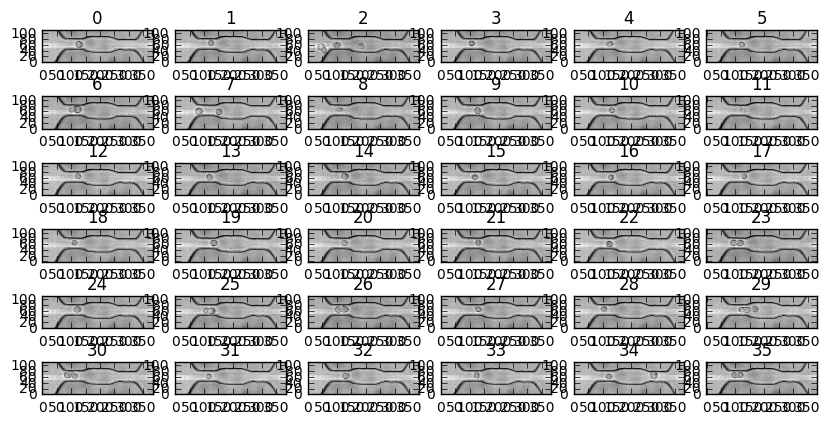

In [16]:
start_index = 0

fig, axes = plt.subplots(6,6, figsize = (10,5))

for i in range(36):
    oi_event = oi_events[i + start_index]
    tf = int((oi_event._detections[0]._tf + oi_event._detections[-1]._tf)/2.)
    
    
    
    column = i/6
    row = i%6
    plt.sca(axes[column, row])
    plt.title(i + start_index)
    
    
    plt.imshow(oi_vid.get_frame(tf), cmap = 'gray', origin = 'lower')

plt.show()

In [18]:
output_file_path = oi_file.ellipse_base_path + date + '/' + particle + '/' + channel + '/' + file_index + '/ellipse_timelapse/'
print output_file_path

/home/prestonh/Desktop/Research/cancer_cells/analysis/data/10-10-2017/HCT-116_1/10-20-10_3/0/ellipse_timelapse/


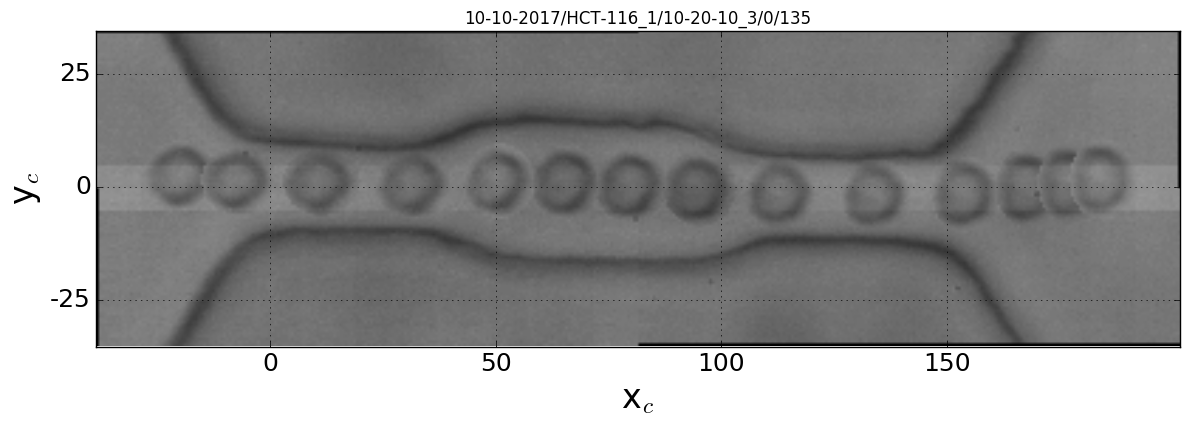

In [20]:
keep_index = 135
oi_index = np.where(np.array(keep_indices) == keep_index)[0][0]
oi_event = oi_events[oi_index]

base_frame = oi_vid.get_frame(0)


fig = plt.figure(figsize = (12,4))

for k, ellipse in enumerate(ellipsess[oi_index]):
    
    if k%5 == 0:# and k != 0 and k != len(ellipsess[oi_index]) - 1:

        ellipse_center = (ellipse[1], ellipse[2])
        ellipse_diameter = np.sqrt(ellipse[3]*ellipse[4])



        ellipse_frame = oi_vid.get_frame(oi_event._detections[int(ellipse[0])]._tf)



        ellipse_pixels = []


        # Height
        for i in range(base_frame.shape[0]):

            # Width
            for j in range(base_frame.shape[1]):
                j - ellipse_center[0]
                theta = np.arctan(1.*(i-ellipse_center[1])/(j - ellipse_center[0]))
                a = ellipse[3]
                b = ellipse[4]
                
                r_of_theta = a*b/np.sqrt((b*np.cos(theta))**2. + (a*np.sin(theta))**2.)
                
                if ((i-ellipse_center[1])**2. + (j-ellipse_center[0])**2.)**.5 < 1.25*r_of_theta:
                    ellipse_pixels.append((i, j))



        for pixel in ellipse_pixels:
            base_frame[pixel[0], pixel[1]] = ellipse_frame[pixel[0], pixel[1]]# + .1
            
            
            
            
            
            
        ellipse_axes_lengths = [ellipse[3], ellipse[4]]
        ellipse_angle = 0
        ellipse_points = np.empty((100,2))
        for i in range(100):
            angle = i*2*np.pi/99.
            x = ellipse_axes_lengths[0]*np.cos(angle)
            y = ellipse_axes_lengths[1]*np.sin(angle)
            ellipse_points[i,0] = ellipse_center[0] + np.cos(ellipse_angle)*x + np.sin(ellipse_angle)*y
            ellipse_points[i,1] = ellipse_center[1] + np.sin(ellipse_angle)*x - np.cos(ellipse_angle)*y
            

        '''
        rot_ellipse_points = np.copy(ellipse_points)
        rot_ellipse_points[:,1] = ellipse_points[:,0]*np.cos(rot_angle) + ellipse_points[:,1]*np.sin(-rot_angle)
        rot_ellipse_points[:,0] = ellipse_points[:,0]*np.sin(-rot_angle) + ellipse_points[:,1]*np.cos(rot_angle)
            
        plt.plot(rot_ellipse_points[:,0], rot_ellipse_points[:,1], color = 'white', ls = ':', lw = 1)'''
        '''plt.plot([oi_stage._origin[0], (oi_stage._origin + oi_stage._length*oi_stage._norm_x)[0]], 
                [oi_stage._origin[1], (oi_stage._origin + oi_stage._length*oi_stage._norm_x)[1]],
                 color = 'white', ls = '--')
        plt.plot([oi_stage._origin[0], (oi_stage._origin + oi_stage._length*oi_stage._norm_y)[0]], 
                [oi_stage._origin[1], (oi_stage._origin + oi_stage._length*oi_stage._norm_y)[1]],
                 color = 'white', ls = '--')'''
        #plt.plot([ellipse[1], ellipse[1] + ellipse[3]], [ellipse[2], ellipse[2]], color = 'white')
        #plt.plot([ellipse[1], ellipse[1]], [ellipse[2], ellipse[2] + ellipse[4]], color = 'white')
            

rot_angle = np.arctan(oi_stage._norm_x[1]/oi_stage._norm_x[0])
base_frame = scipy.ndimage.interpolation.rotate(base_frame, rot_angle)
plt.imshow(base_frame, cmap = 'gray', origin = 'lower', vmin = 0, vmax = 0.5)

plt.title(date + '/' + particle + '/' + channel + '/' + file_index + '/' + str(keep_index))

xticks = plt.gca().get_xticks()
yticks = plt.gca().get_yticks()
ys = [0,50,100,150]
xs = []
for y in ys:
    xs.append(oi_stage.meters_to_pixels(y) + oi_stage._origin[0])
plt.xticks(xs, ys)


ys = [-25,0,25]
xs = []
for y in ys:
    xs.append(oi_stage.meters_to_pixels(y) + oi_stage._origin[1])
plt.yticks(xs, ys)

plt.tick_params(labelsize = 18)

plt.xlabel('x$_{c}$', size = 24)
plt.ylabel('y$_{c}$', size = 24)


plt.grid()

fig.tight_layout()


plt.savefig(output_file_path + 'multi-deformation_' + str(keep_index) + '.png', dpi = 100)

plt.show()
